In [9]:
import pyvista as pv
from pyvista import examples
import tetgen

import numpy as np
import radia as rad

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from tqdm import tqdm
import pickle

def setup_axes(fig, rows, cols, subplot, title='', proj='persp', elev=20, azim=-80, x=(-1, 1, 5), z=(-1, 1, 5), s=(-1, 1, 5)):
    ax = fig.add_subplot(rows, cols, subplot, projection='3d')
    ax.set_proj_type(proj)
    ax.view_init(elev=elev, azim=azim)
    ax.set_box_aspect([1,1,1])
    ax.xaxis.pane.fill, ax.yaxis.pane.fill, ax.zaxis.pane.fill = False, False, False
    ax.set_xlabel('X Axis')
    ax.set_zlabel('Z Axis (Transverse)')
    ax.set_ylabel('S Axis')
    ax.set_xlim3d(*x[:2])
    ax.set_zlim3d(*z[:2])
    ax.set_ylim3d(*s[:2])
    ax.set_xticks(np.linspace(*x))
    ax.set_zticks(np.linspace(*z))
    ax.set_yticks(np.linspace(*s))
    ax.set_title(title, fontdict={'size': 22})
    return ax

def plot_radia_object(ax, obj, color, matrix):
    polygons = rad.ObjDrwVTK(obj, 'Axes->False')['polygons']
    lengths  = polygons['lengths']
    vertices = np.reshape(polygons['vertices'], (-1, 3))
    vertices = np.array(transform_points(vertices, matrix))
    
    idx = 0
    faces = []
    for length in lengths:
        faces += [vertices[idx:(idx+length), [0, 2, 1]]]
        idx += length
        
    ax.add_collection3d(Poly3DCollection(faces, facecolors=[color], edgecolors=['k'], 
                                         linewidth=0.02, alpha=0.04))
    
def transform_points(lattice, matrix):
    lattice = np.concatenate([lattice, np.ones(lattice.shape[:-1] + (1,))], axis=-1)
    return (lattice @ matrix)[..., :-1]

def radians(degrees):
    return degrees * (np.pi / 180.0)

def rotate_x(theta):
    c, s = np.cos(theta), np.sin(theta)
    return np.array([[ 1,  0,  0,  0],
                     [ 0,  c, -s,  0],
                     [ 0,  s,  c,  0],
                     [ 0,  0,  0,  1]],
                    dtype=np.float32).T

def scale(x, z, s):
    return np.array([[x, 0, 0, 0],
                     [0, z, 0, 0],
                     [0, 0, s, 0],
                     [0, 0, 0, 1]],
                    dtype=np.float32).T

In [10]:
matrix = scale(2, 2, 2) @ rotate_x(radians(90))

# Starting with the basic Stanford Bunny Triangular Mesh
bunny_mesh = examples.download_bunny_coarse()

# Extract (F, 3) face list
bunny_faces = bunny_mesh.faces.reshape((-1, 4))[:, 1:]

# Extact (V, 3) vertex list transformed into the world
bunny_points = transform_points(bunny_mesh.points, matrix)

# Extract (F, 3, 3) list of vertices for each face
bunny_triangles = bunny_points[bunny_faces]

# Use TetGen to compute a tetrahedralized mesh from the triangular mesh
tet = tetgen.TetGen(bunny_points.tolist(), bunny_faces.tolist())
tet.tetrahedralize(order=1, mindihedral=20, minratio=1.5, nobisect=False)

# Extract (T, 4) the tetrahedron vertex lists
bunny_tet_cells  = tet.grid.cells.reshape(-1, 5)[:, 1:]

# Extract (T, 4, 3) list of vertices for each face for each tetrahedron
bunny_tet_points = tet.grid.points[bunny_tet_cells]

In [11]:
# Filter the tetrahedral mesh to hide anything above 0 on the Z axis
cell_ind = (tet.grid.points[bunny_tet_cells].mean(1)[:, 2] < 0).nonzero()[0]
subgrid  = tet.grid.extract_cells(cell_ind)
bunny_cuttet_cells  = subgrid.cells.reshape(-1, 5)[:, 1:]
bunny_cuttet_points = subgrid.points[bunny_cuttet_cells]

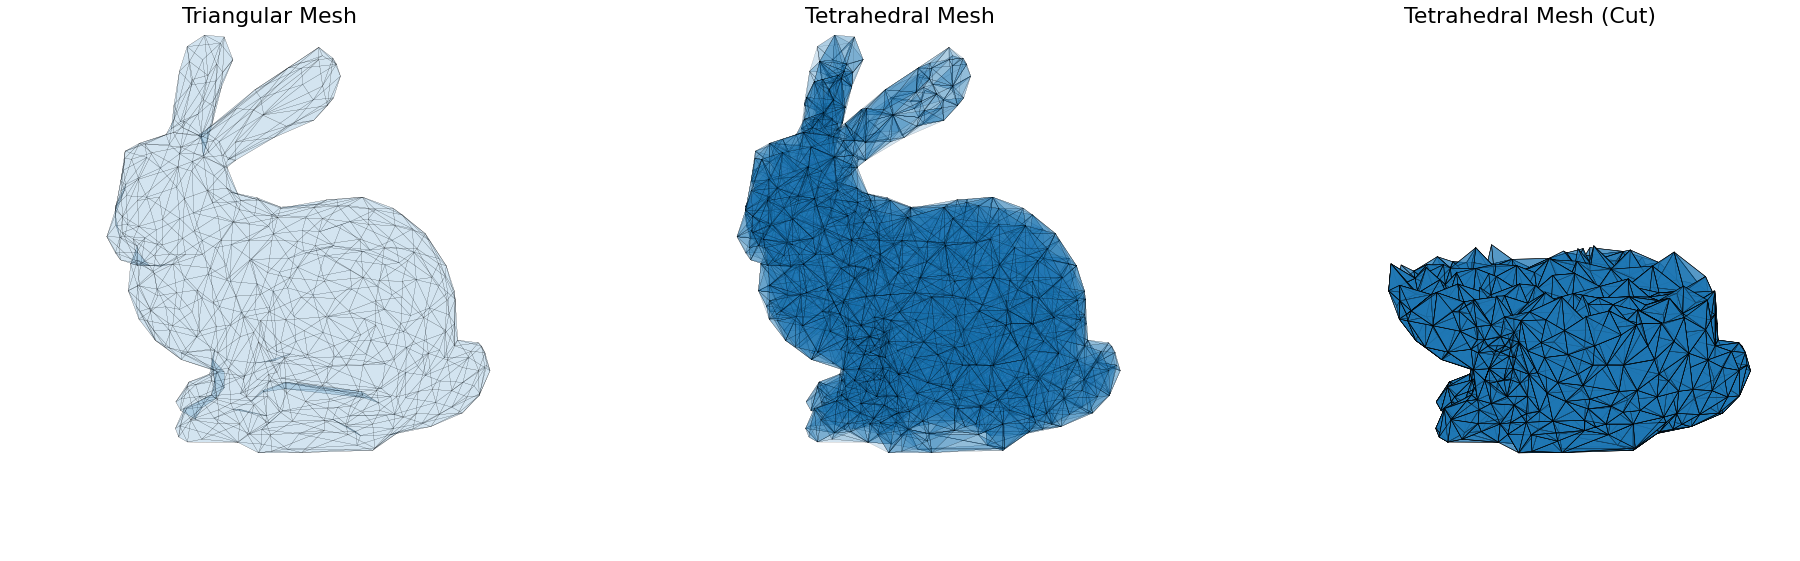

In [12]:
matrix = scale(4, 4, 4)
cmap = plt.get_cmap('tab10')

subplot, rows, cols = 0, 1, 3
fig = plt.figure(figsize=(32,12), facecolor='w')

subplot += 1
ax = setup_axes(fig, rows, cols, subplot, title='Triangular Mesh')
ax.axis('off')

ax.add_collection3d(Poly3DCollection(transform_points(bunny_triangles, matrix), 
                                     facecolors=[cmap(0)], edgecolors=['k'], linewidth=0.1, alpha=0.1))

subplot += 1
ax = setup_axes(fig, rows, cols, subplot, title='Tetrahedral Mesh')
ax.axis('off')

faces = [[0, 1, 2], [1, 2, 3], [2, 3, 0], [3, 0, 1]]

ax.add_collection3d(Poly3DCollection([[tet[vertex] for vertex in face] for tet in transform_points(bunny_tet_points, matrix) for face in faces], 
                                     facecolors=[cmap(0)], edgecolors=['k'], linewidth=0.05, alpha=0.1))

subplot += 1
ax = setup_axes(fig, rows, cols, subplot, title='Tetrahedral Mesh (Cut)')
ax.axis('off')

faces = [[0, 1, 2], [1, 2, 3], [2, 3, 0], [3, 0, 1]]

ax.add_collection3d(Poly3DCollection([[tet[vertex] for vertex in face] for tet in transform_points(bunny_cuttet_points, matrix) for face in faces], 
                                     facecolors=[cmap(0)], edgecolors=['k'], linewidth=0.5, alpha=0.5))

plt.show()

In [13]:
# Faces of a tetrahedra
faces = [[0, 1, 2], [1, 2, 3], [2, 3, 0], [3, 0, 1]]

# Set of tetrahedra for mesh
polyhedra = []
for cell in tet.grid.cells.reshape(-1, 5)[:, 1:]:
    polyhedra += [[[int(cell[vertex]) for vertex in face] for face in faces]]

# Permute XZS to XYZ for rendering
vertices = tet.grid.points.astype(np.float32)[:, [0, 2, 1]]

# Field vector of the magnets
vector = [0, 0.01, 0]

# Convert set of tetrahedra to radia group
obj = []
for poly in polyhedra:

    # Find the vertices used by this polyhedra
    used_ids = sorted(list(set(vertex for face in poly for vertex in face)))

    # Extract a minimal vertex list of just the points used by this polyhedra
    local_vertices = [vertices[global_id].tolist() for global_id in used_ids]

    # Create a lookup table mapping vertex ids in the full list to those in them minimal list
    map_ids  = { global_id: local_id for local_id, global_id in enumerate(used_ids)}

    # Create a face list using the minimal vertex list
    faces = [[(map_ids[global_id] + 1) for global_id in face] for face in poly]

    # Create a radia object for this polyhedra
    obj += [rad.ObjPolyhdr(local_vertices, faces, vector)]

bunny_radia = rad.ObjCnt(obj) if len(obj) > 1 else obj[0]

In [14]:
def compute_field_stream(obj, seed, steps, rate):
    
    point = np.array(seed, dtype=np.float32)
    
    forward_vertices = [point]
    for step in range(steps // 2):
        
        vector = np.array(rad.Fld(obj, 'b', point.tolist()), dtype=np.float32)
        
        norm = np.linalg.norm(vector, axis=-1)
        
        if np.max(norm) < 1e-6:
            break
        
        point = point + ((vector / norm) * rate)
        
        forward_vertices += [point]
        
    point = np.array(seed, dtype=np.float32)
        
    backward_vertices = []
    for step in range(steps // 2):
        
        vector = np.array(rad.Fld(obj, 'b', point.tolist()), dtype=np.float32)
        
        norm = np.linalg.norm(vector, axis=-1)
        
        if np.max(norm) < 1e-6:
            break
        
        point = point - ((vector / norm) * rate)
        
        backward_vertices += [point]
        
    vertices = np.stack((backward_vertices[::-1] + forward_vertices), axis=0)[:, [0, 2, 1]]
    
    return vertices

In [15]:
# # Start a stream curve based around each vertex in the tetrahedral mesh
# seeds = bunny_obj.vertices

# # Add some random noise to offset stream curves from vertices
# jitter = 1e-3
# seeds += np.random.uniform(low=-jitter, high=jitter, size=seeds.shape)

# # Compute the stream curve from each seed
# streams = []
# for seed in tqdm(seeds):
#     streams += [compute_field_stream(bunny_radia, seed, steps=500, rate=0.01)]

# # Cache the result to disk
# with open('streams.pkl', 'wb') as fp:
#     pickle.dump(streams, fp)

In [ ]:
# Use the cached stream curves
with open('streams.pkl', 'rb') as fp:
    streams = pickle.load(fp)

fig = plt.figure(figsize=(64, 64))
ax = Axes3D(fig, proj_type='persp')
ax.view_init(elev=0, azim=-90)
ax.set_xlabel('X Axis')
ax.set_ylabel('S Axis')
ax.set_zlabel('Z Axis (Transverse)')
ax.xaxis.pane.fill, ax.yaxis.pane.fill, ax.zaxis.pane.fill = False, False, False
ax.axis('off')
ax.set_box_aspect([1, 1, 1])
ax.set_xlim3d(-2, 2)
ax.set_ylim3d(-2, 2)
ax.set_zlim3d(-2, 2)

matrix = scale(2, 2, 2)

plot_radia_object(ax, bunny_radia, cmap(0), matrix)

for vertices in streams:
    vertices = np.array(transform_points(vertices[:, [0, 2, 1]], matrix))[:, [0, 2, 1]]
    ax.plot(*(vertices.T), color=[0.4, 0.4, 0.5], alpha=0.3, linewidth=0.6) 

plt.show()    